In [1]:
import os.path
from functools import reduce

import alphalens as al
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def resample(xs, rule='30min'):
    resampled = xs.set_index('OpenTime').resample(rule)
    ys = pd.DataFrame(data={
        'Open': resampled.Open.first(),
        'High': resampled.High.max(),
        'Low': resampled.Low.min(),
        'Close': resampled.Close.last(),
        'NumberOfTrades': resampled.NumberOfTrades.sum(),
        # 'QuoteAssetVolume': resampled.QuoteAssetVolume.sum(),
        'TakerBuyBaseAssetVolume': resampled.TakerBuyBaseAssetVolume.sum(),
        'TakerBuyQuoteAssetVolume': resampled.TakerBuyQuoteAssetVolume.sum(),
        'Volume': resampled.Volume.sum(),
    })
    ys = ys[ys.Volume > 1]
    ys = ys.reset_index()
    delta = ys.OpenTime.iloc[-1] - ys.OpenTime.iloc[-2]
    ys['CloseTime'] = ys.OpenTime.add(delta)
    ys['date'] = ys.CloseTime
    return ys


def prep(data):
    def f(tup):
        name, xs = tup
        xs['asset'] = name
        return xs

    append = lambda a, b: a.append(b)
    xs = reduce(append, map(f, data.items()))
    if True:
        full = xs.groupby('date').asset.count() == len(data)
        mask = xs.date.map(lambda date: full[date])
        xs = xs[mask]
    xs = xs.sort_values(['date', 'asset'])
    xs = xs.set_index(['date', 'asset'])
    return xs


def read(xs, rule, start=None, end=None, **kwargs):
    if start:
        kwargs.setdefault('filters', [])
        kwargs['filters'].append(('Date', '>=', start))
    if end:
        kwargs.setdefault('filters', [])
        kwargs['filters'].append(('Date', '<', end))
    k = {}
    for x in xs:
        path = os.path.expanduser(f'~/data/futures/{x}USDT')
        data = pd.read_parquet(path, **kwargs)
        k[x] = resample(data, rule)
    return prep(k)


def prices(data):
    return data.Close.unstack('asset')

In [3]:
def visualize_returns(ps, period=1, figsize=None):
    from sklearn.preprocessing import MinMaxScaler

    rs = ps.pct_change(period)
    xs = pd.DataFrame(data={'price': ps, 'return': rs}).dropna()

    scaler = MinMaxScaler(feature_range=(0, 0.25))
    scaled = scaler.fit_transform(xs['price'].to_numpy().reshape(-1, 1)) + 0.1
    if figsize:
        plt.figure(figsize=figsize)
    plt.bar(xs.index, xs['return'], label=f'return (period={period})')
    plt.plot(xs.index, scaled, label='price', color='red')
    plt.legend()
    plt.show()

In [4]:
data = read(['BTC', 'ETH'], '1D', start='2020-06-01', end='2021-01-01')

In [5]:
xs = prices(data)
xs

asset,BTC,ETH
date,,
2020-06-02 00:00:00+00:00,10232.48,248.90
2020-06-03 00:00:00+00:00,9514.90,237.73
2020-06-04 00:00:00+00:00,9663.59,244.52
2020-06-05 00:00:00+00:00,9788.33,243.28
2020-06-06 00:00:00+00:00,9617.29,240.13
...,...,...
2020-12-28 00:00:00+00:00,26305.64,685.11
2020-12-29 00:00:00+00:00,27102.66,731.07
2020-12-30 00:00:00+00:00,27402.83,733.45


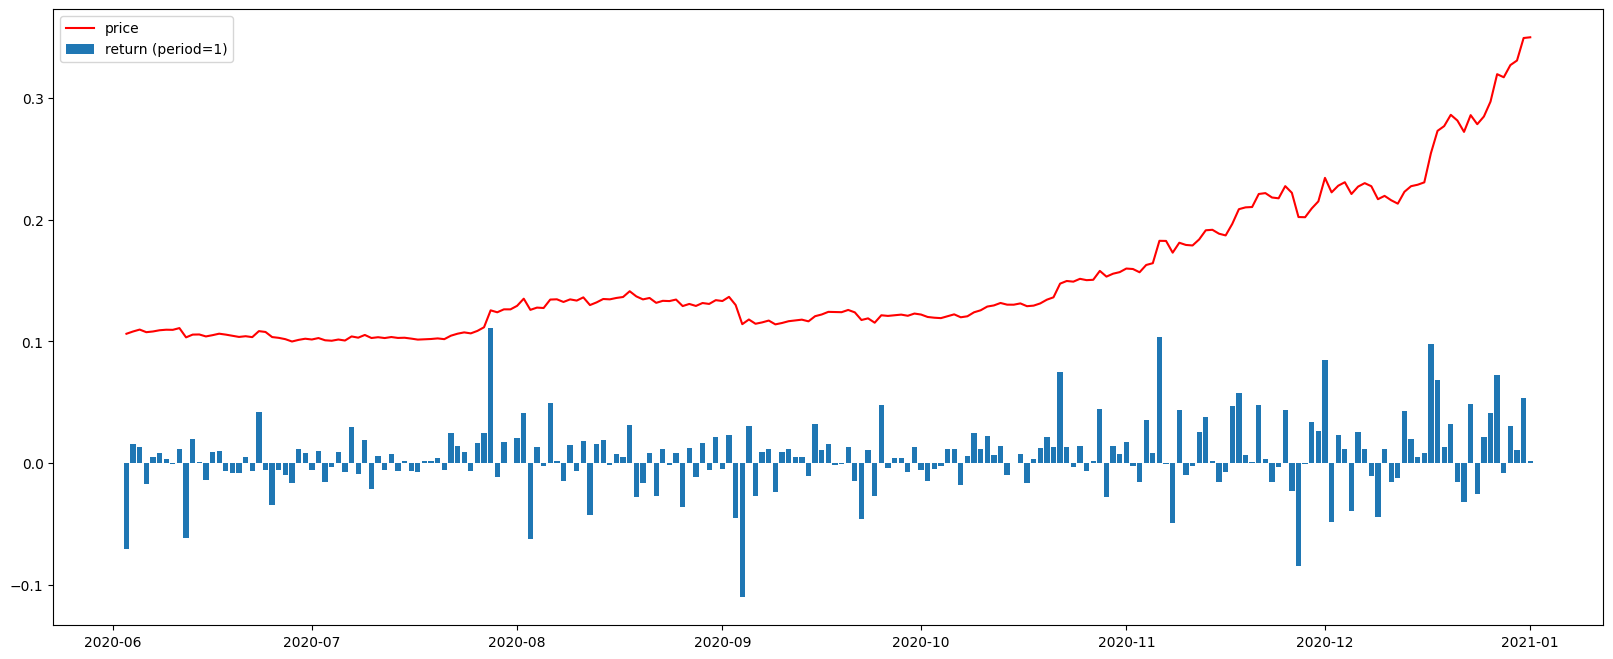

In [6]:
visualize_returns(xs.BTC, figsize=(20, 8))